***TIMEIT get_all_data TOOK: 0.988 s
                          kWh     t_ref  n_jump  n_exec   p_max  p_mean  p_min
ts                                                                            
2016-09-04 11:00:00  0.340372  1.000113       0       0  2564.0   340.0  217.0
2016-09-04 12:00:00  0.379681  1.000058       0       0   884.0   380.0  213.0
2016-09-04 13:00:00  0.392073  0.999846       0       0  1277.0   392.0  289.0
2016-09-04 14:00:00  0.749654  0.999962       0       0  2606.0   750.0  311.0
2016-09-04 15:00:00  0.277414  0.421684       0       0   903.0   658.0  354.0
                ldr
count  1.874958e+06
mean   2.661204e+02
std    2.426892e+02
min    1.100000e+01
25%    3.300000e+01
50%    1.940000e+02
75%    5.050000e+02
max    7.480000e+02


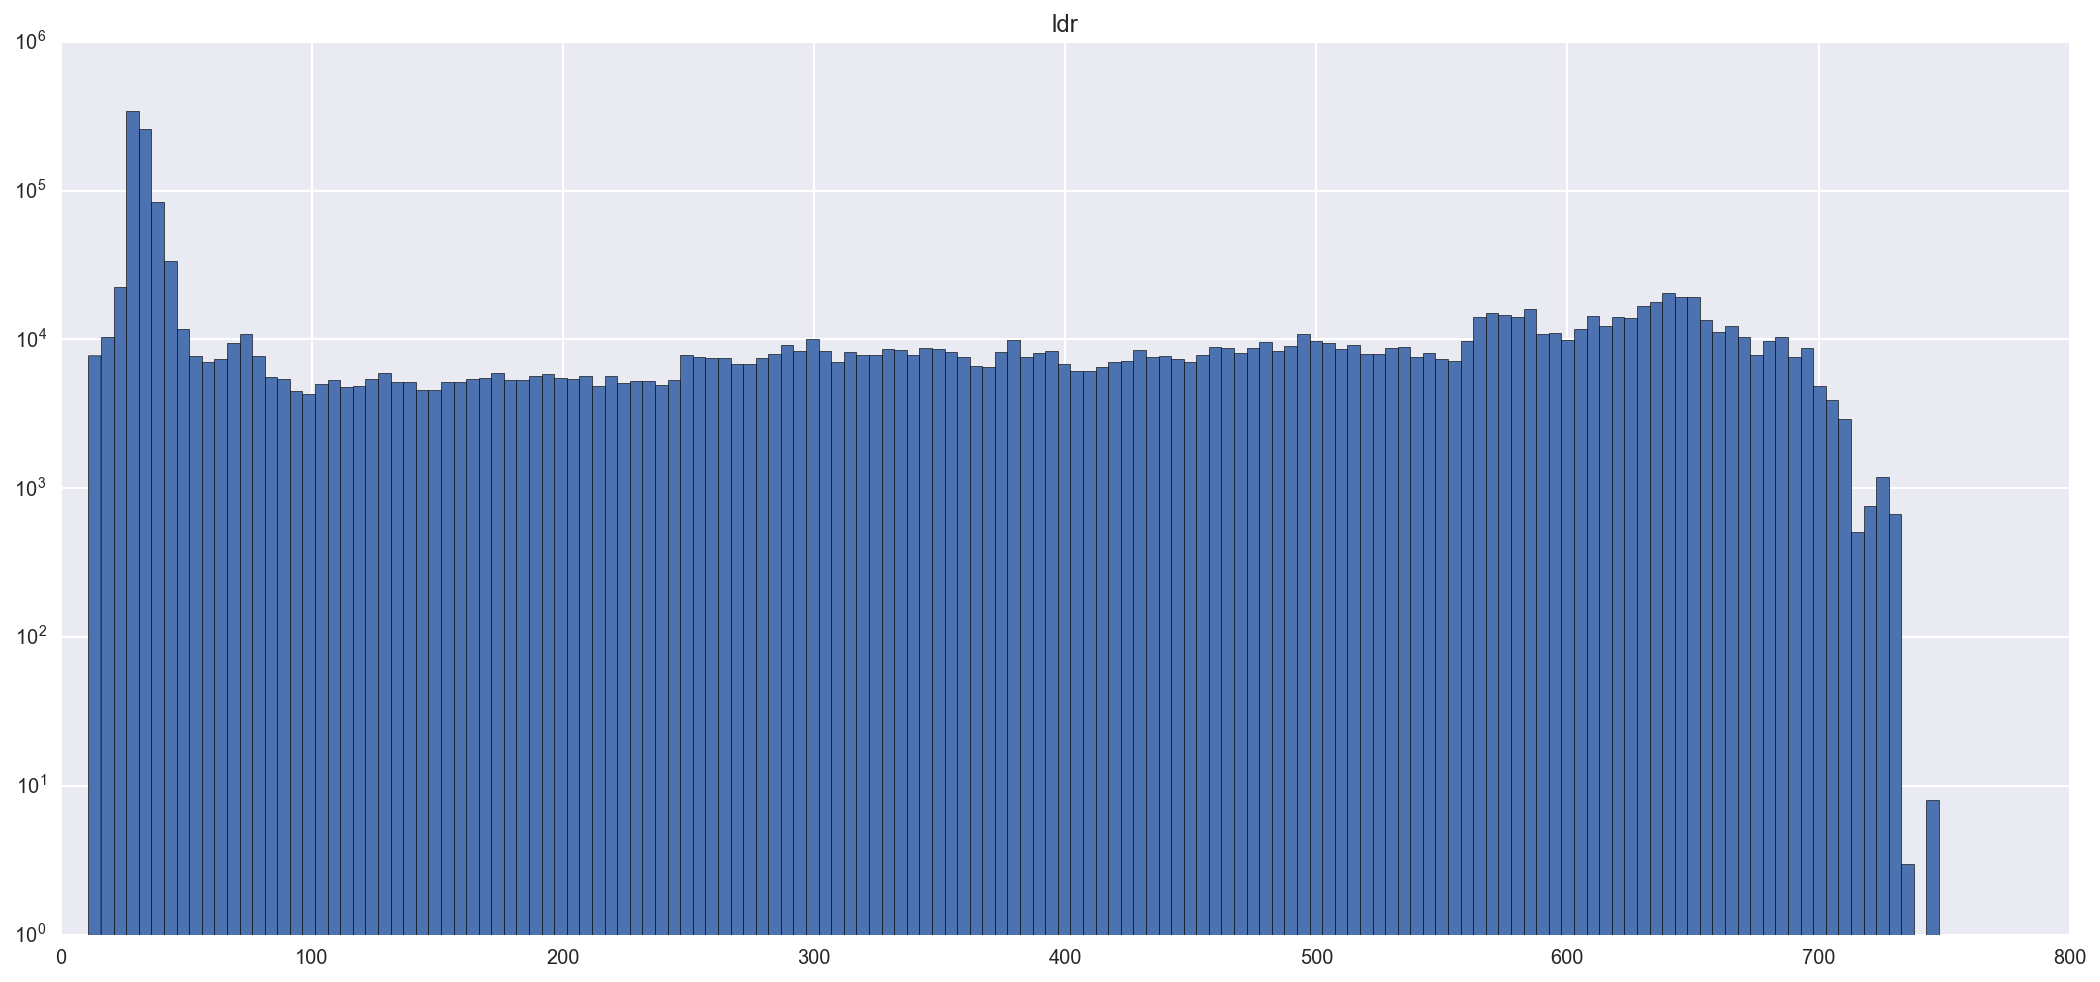

In [163]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from datacharm import *
from enerpi.api import enerpi_data_catalog
from enerpi.enerplot import plot_tile_last_24h, plot_power_consumption_hourly
import random
import math
import pysolar
import datetime as dt
import pytz
import matplotlib.dates as mpd


LAT, LONG = 38.631463, -0.866402
TZ = pytz.timezone('Europe/Madrid')


def _tslim(ax, h0=12, hf=22, m0=0, mf=0):
    xlim = [mpd.num2date(x, tz=TZ) for x in ax.get_xlim()]
    new = [mpd.date2num(d.replace(hour=h, minute=m)) for d, h, m in zip(xlim, [h0, hf], [m0, mf])]
    ax.set_xlim(new)
    return ax


# Catálogo y lectura de todos los datos.
cat = enerpi_data_catalog()
data, data_s = cat.get_all_data()
print_info(data_s.tail())

LDR = pd.DataFrame(data.ldr).tz_localize(TZ)

print_cyan(LDR.describe())
LDR.hist(bins=(LDR.max() - LDR.min() + 1).values[0] // 5, log=True, figsize=(18, 8));

In [81]:
# Plot day
def _get_rday(data):
    t0 = data.index[0].date()
    tf = data.index[-1].date()
    delta = tf - t0
    rd = random.randrange(0, delta.days + 1, 1)
    day = t0 + dt.timedelta(days=rd)
    return data.loc[day.strftime('%Y-%m-%d'):day.strftime('%Y-%m-%d')]


def _alt_azi(d):
    return pysolar.solar.get_altitude(LAT, LONG, d), pysolar.solar.get_azimuth(LONG, LAT, d)


def get_solar_day(day=dt.datetime.today(), step_minutes=5, tz=TZ, step_calc_seg=30):
    if (type(day) is pd.DataFrame) or (type(day) is pd.Series):
        df_sol = pd.DataFrame(day)
        
        sunrise, sunset = pysolar.util.get_sunrise_sunset(LAT, LONG, df_sol.index[0])
        df_sol.loc[(sunrise > df_sol.index) | (sunset < df_sol.index), 'altitud'] = 0
        
        idx_calc_solar = df_sol.index[df_sol['altitud'].isnull()][::step_calc_seg]
        alts = [pysolar.solar.get_altitude(LAT, LONG, d) for d in idx_calc_solar]
        azims = [pysolar.solar.get_azimuth(LAT, LONG, d) for d in idx_calc_solar]
        irrads = [pysolar.radiation.get_radiation_direct(d, alt) if alt > 0 else 0 for d, alt in zip(idx_calc_solar, alts)]
        df_sol.loc[idx_calc_solar, 'altitud'] = alts
        df_sol.loc[idx_calc_solar, 'azimut'] = azims
        df_sol.loc[idx_calc_solar, 'irradiacion_cs'] = irrads
        #df_sol.altitud = df_sol.altitud.where(df_sol.altitud > 0, other=0)
        #df_sol['irradiacion_cs'] = df_sol.apply(lambda x: pysolar.radiation.get_radiation_direct(x.name, x['altitud']), axis=1)
        df_sol = df_sol.interpolate().fillna(0)
    else:
        day = tz.localize(day).replace(hour=0, minute=0, second=0, microsecond=0)
        tt = [day + dt.timedelta(minutes=m) for m in range(0, 24 * 60, step_minutes)]
        df_sol = pd.DataFrame([_alt_azi(d) for d in tt], columns=['altitud', 'azimut'], index=tt)
        df_sol.altitud = df_sol.altitud.where(df_sol.altitud > 0, other=0)
        df_sol['irradiacion_cs'] = df_sol.apply(lambda x: pysolar.radiation.get_radiation_direct(x.name, x['altitud']), axis=1)
    return df_sol


df_sol = get_solar_day(day=dt.datetime.today(), step_minutes=5)

data_day = get_solar_day(_get_rday(LDR))
data_day.head()

/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


,ldr,altitud,azimut,irradiacion_cs
ts,,,,
2016-09-03 00:00:00.403474+02:00,37,0.0,0.0,0.0
2016-09-03 00:00:01.405182+02:00,36,0.0,0.0,0.0
2016-09-03 00:00:02.406490+02:00,37,0.0,0.0,0.0
2016-09-03 00:00:03.411424+02:00,37,0.0,0.0,0.0
2016-09-03 00:00:04.413010+02:00,37,0.0,0.0,0.0


                ldr       altitud        azimut  irradiacion_cs
count  85716.000000  85716.000000  85716.000000    85716.000000
mean     276.929336     18.409681   -112.710343      371.476877
std      268.251264     21.813714    120.310058      394.108308
min       14.000000     -2.098214   -359.911983        0.000000
25%       30.000000      0.000000   -264.202070        0.000000
50%      161.000000      4.692009    -81.619398      104.911947
75%      575.000000     38.845697      0.000000      825.770004
max      730.000000     58.661027      0.000000      896.512045
AZIMUT RANGE: 0 --> -360 sentido horario, comienza en SUR. W=-90, N=-180, E=-270, S=0/-360


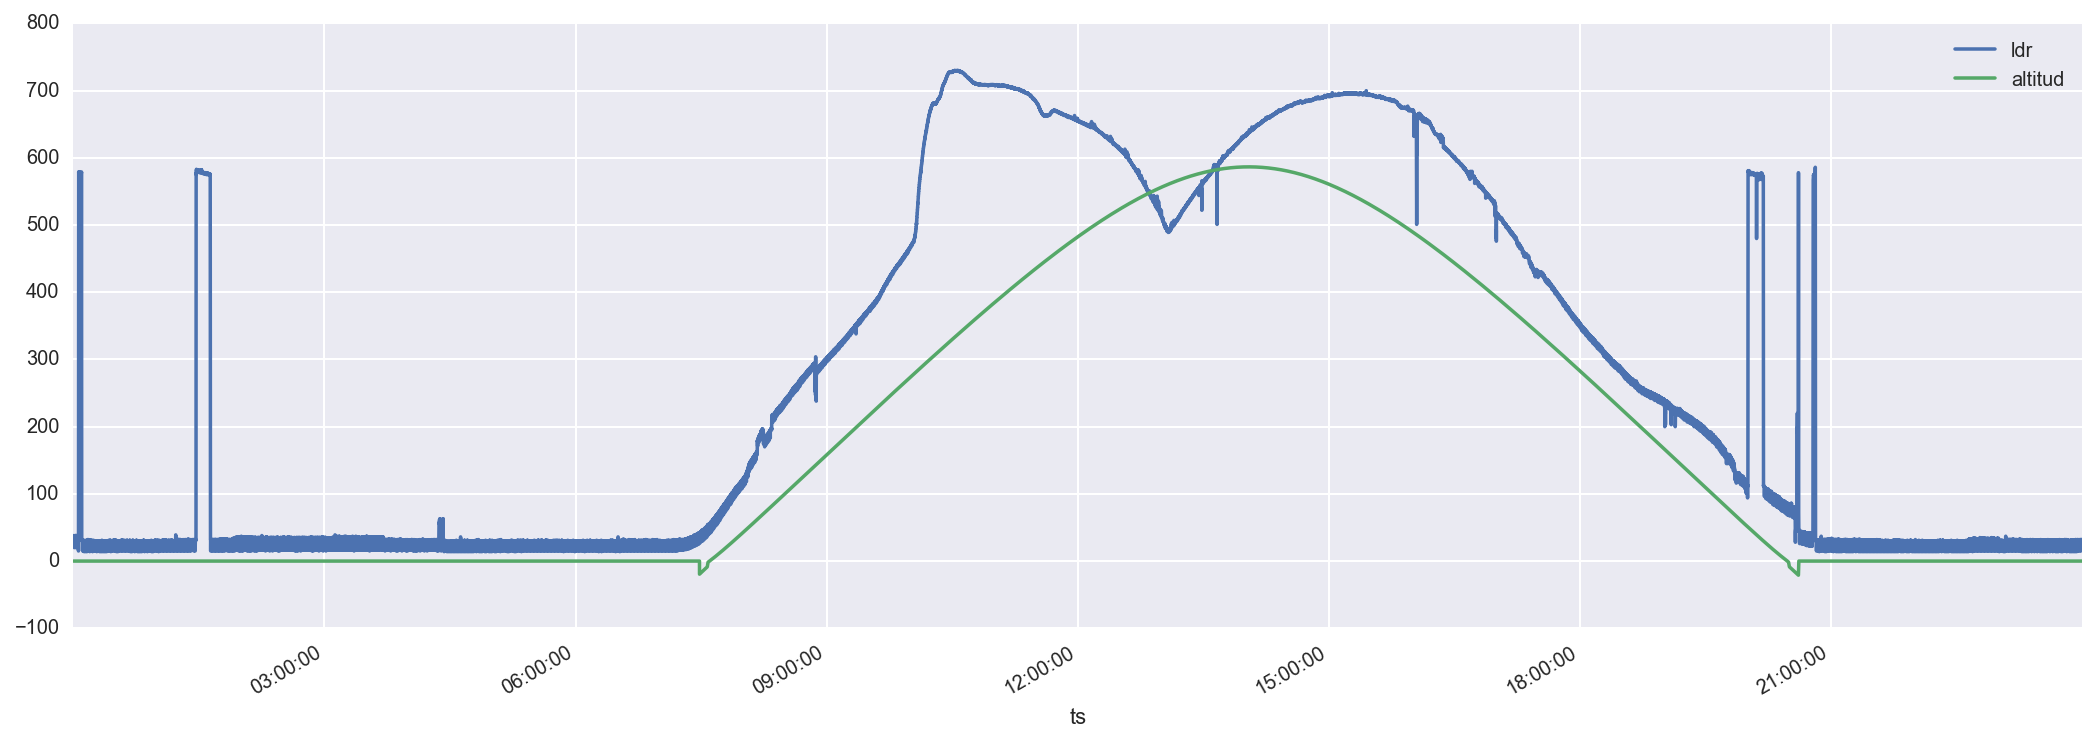

In [82]:
df_sol_p = data_day.copy()
print_red(df_sol_p.describe())
df_sol_p.altitud *= 10.
#df_sol_p.azimut += 180.
#df_sol_p.azimut *= -1.
df_sol_p[['ldr', 'altitud']].plot(figsize=(18, 6));
print_magenta('AZIMUT RANGE: 0 --> -360 sentido horario, comienza en SUR. W=-90, N=-180, E=-270, S=0/-360')

In [298]:

    
idx_calc_solar[0]
#[pysolar.solar.get_azimuth(LAT, LONG, d) for d in idx_calc_solar]

Timestamp('2016-08-27 07:21:05.097442+0200', tz='Europe/Madrid')

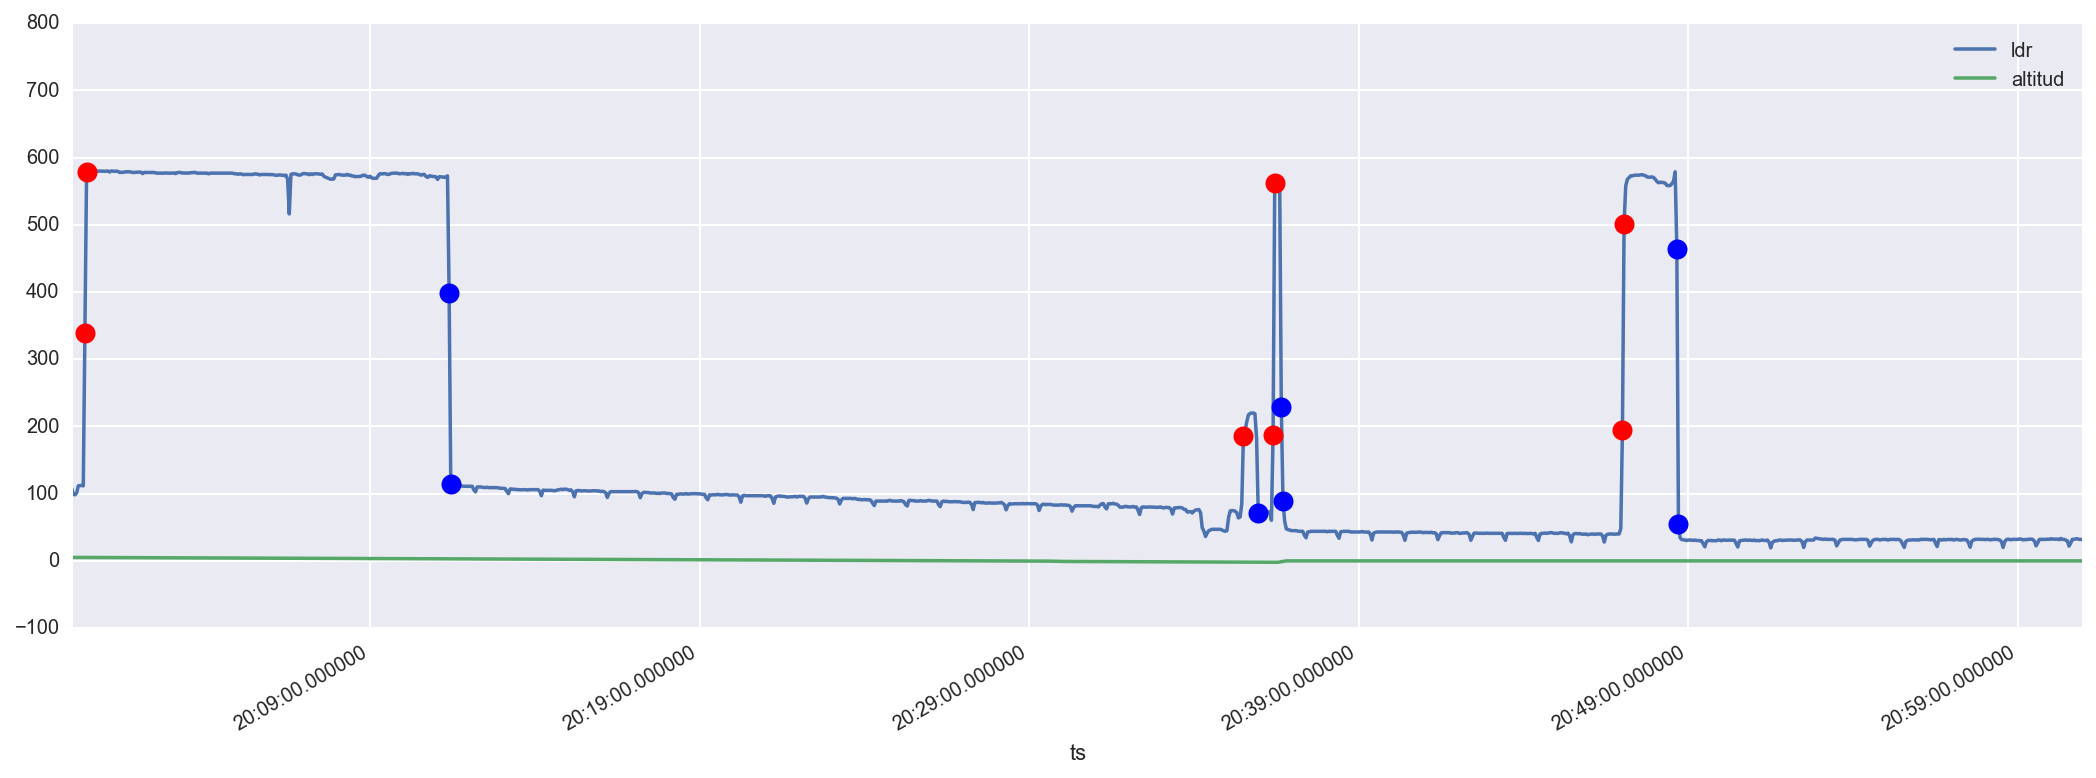

In [126]:
d_rs['d_ldr'] = d_rs.ldr.diff().fillna(0)
d_rs['on'] = d_rs['d_ldr'] > 100
d_rs['off'] = d_rs['d_ldr'] < -100

ax = d_rs[['ldr', 'altitud']].plot(figsize=(18, 6));
d_rs[d_rs['on']].ldr.plot(lw=0, marker='o', markersize=10, color='red')
d_rs[d_rs['off']].ldr.plot(lw=0, marker='o', markersize=10, color='blue')
_tslim(ax, 20, 21)

/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


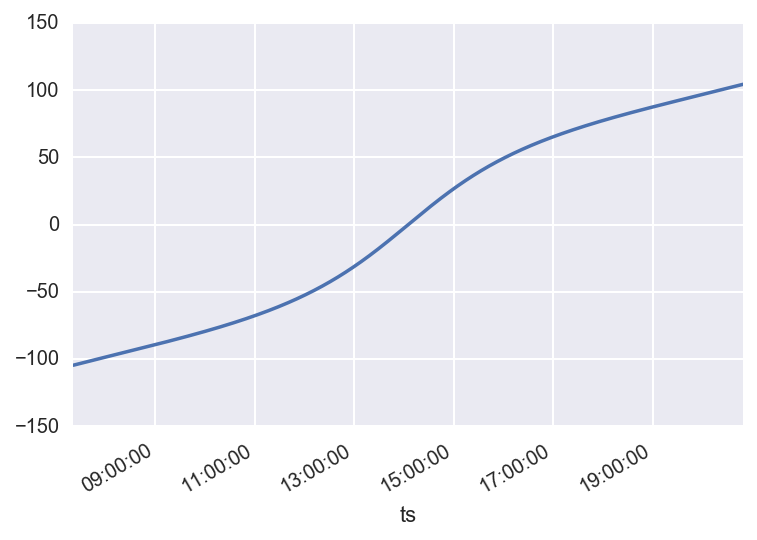

In [315]:
def _azimut_S(azi):
    if azi + 180 < 0:
        return -(360 + azi)
    return -azi

azimuts = pd.Series([_azimut_S(pysolar.solar.get_azimuth(LAT, LONG, d)) for d in idx_calc_solar], index=idx_calc_solar)
azimuts.plot()

In [266]:
def _f_roll(x):
    delta_pos = np.sum(x[x > 0])
    delta_neg = np.sum(x[x < 0])
    return delta_pos + delta_neg

#def _f_state(delta):
#    if delta > 100:
#        return 1
#    elif delta < -100:
#        return -1
#    return 0

def _min_max_rel(x):
    mid = x[len(x) // 2]
    if mid == np.max(x):
        return 1
    elif mid == np.min(x):
        return -1
    return 0


def _first_on(x):
    if (np.sum(x) == 1.) & (x[-1] == 1.):
        return True
    return False

def _last_on(x):
    if (np.sum(x) == 1.) & (x[-1] == 1.):
        return True
    return False


# TODO Resolver NaN's
resample_inicial = '2s'
delta_roll_threshold = 100

data_analysis = data_day[['ldr', 'altitud', 'azimut', 'irradiacion_cs']].resample(resample_inicial).mean()

data_analysis['delta_roll'] = data_analysis.ldr.diff().fillna(0).rolling(3, center=True).apply(_f_roll).fillna(0)
data_analysis['on'] = data_analysis['delta_roll'] > delta_roll_threshold
data_analysis['off'] = data_analysis['delta_roll'] < -delta_roll_threshold

data_analysis['on'].rolling?
data_analysis['ch_state'] = 0
data_analysis.loc[data_analysis[data_analysis['on'].rolling(3).apply(_first_on).fillna(False) > 0].index, 'ch_state'] = 1
data_analysis.loc[data_analysis[data_analysis['off'].rolling(3).apply(_last_on).fillna(False) > 0].index, 'ch_state'] = -1

#print_red(data_analysis[data_analysis['on']])


#data_analysis['light_state'] = data_analysis['delta_roll'].apply(_f_state)

#data_analysis['state_ch'] = data_analysis['delta_roll'].rolling(3, center=True).apply(_min_max_rel)
#encendidos = data_analysis[data_analysis['on'].rolling(3).apply(_first_on).fillna(False) > 0]
#data_analysis[data_analysis['on'] & (data_analysis['state_ch'] == 1)]
#apagados = data_analysis[data_analysis['off'].rolling(3).apply(_last_on).fillna(False) > 0]
#data_analysis[data_analysis['off'] & (data_analysis['state_ch'] == -1)]

#print_info(encendidos[['ldr','delta_roll', 'on', 'off', 'state_ch']])
#apagados[['ldr','delta_roll', 'on', 'off', 'state_ch']]
#[['ldr','delta_roll', 'on', 'off', 'state_ch']]

cambios = data_analysis[data_analysis['ch_state'] != 0]
cambios

Object `rolling` not found.


,ldr,altitud,azimut,irradiacion_cs,delta_roll,on,off,ch_state
ts,,,,,,,,
2016-09-03 00:03:40+02:00,81.0,0.000000,0.000000,0.000000,446.5,True,False,1
2016-09-03 00:03:54+02:00,579.0,0.000000,0.000000,0.000000,-183.5,False,True,-1
2016-09-03 00:04:30+02:00,32.0,0.000000,0.000000,0.000000,191.0,True,False,1
2016-09-03 00:05:12+02:00,495.0,0.000000,0.000000,0.000000,-467.0,False,True,-1
2016-09-03 00:05:32+02:00,32.0,0.000000,0.000000,0.000000,151.5,True,False,1
2016-09-03 00:05:50+02:00,561.0,0.000000,0.000000,0.000000,-339.0,False,True,-1
2016-09-03 01:27:52+02:00,35.0,0.000000,0.000000,0.000000,172.5,True,False,1
2016-09-03 01:38:04+02:00,534.5,0.000000,0.000000,0.000000,-407.5,False,True,-1
2016-09-03 16:02:44+02:00,602.5,48.576025,-48.614800,868.626059,-130.0,False,True,-1


Encendido L=579, SEGS=14
Encendido L=578, SEGS=42
Encendido L=578, SEGS=18
Encendido L=582, SEGS=612
Encendido L=581, SEGS=664
Encendido L=220, SEGS=26
Encendido L=576, SEGS=14
Encendido L=585, SEGS=100


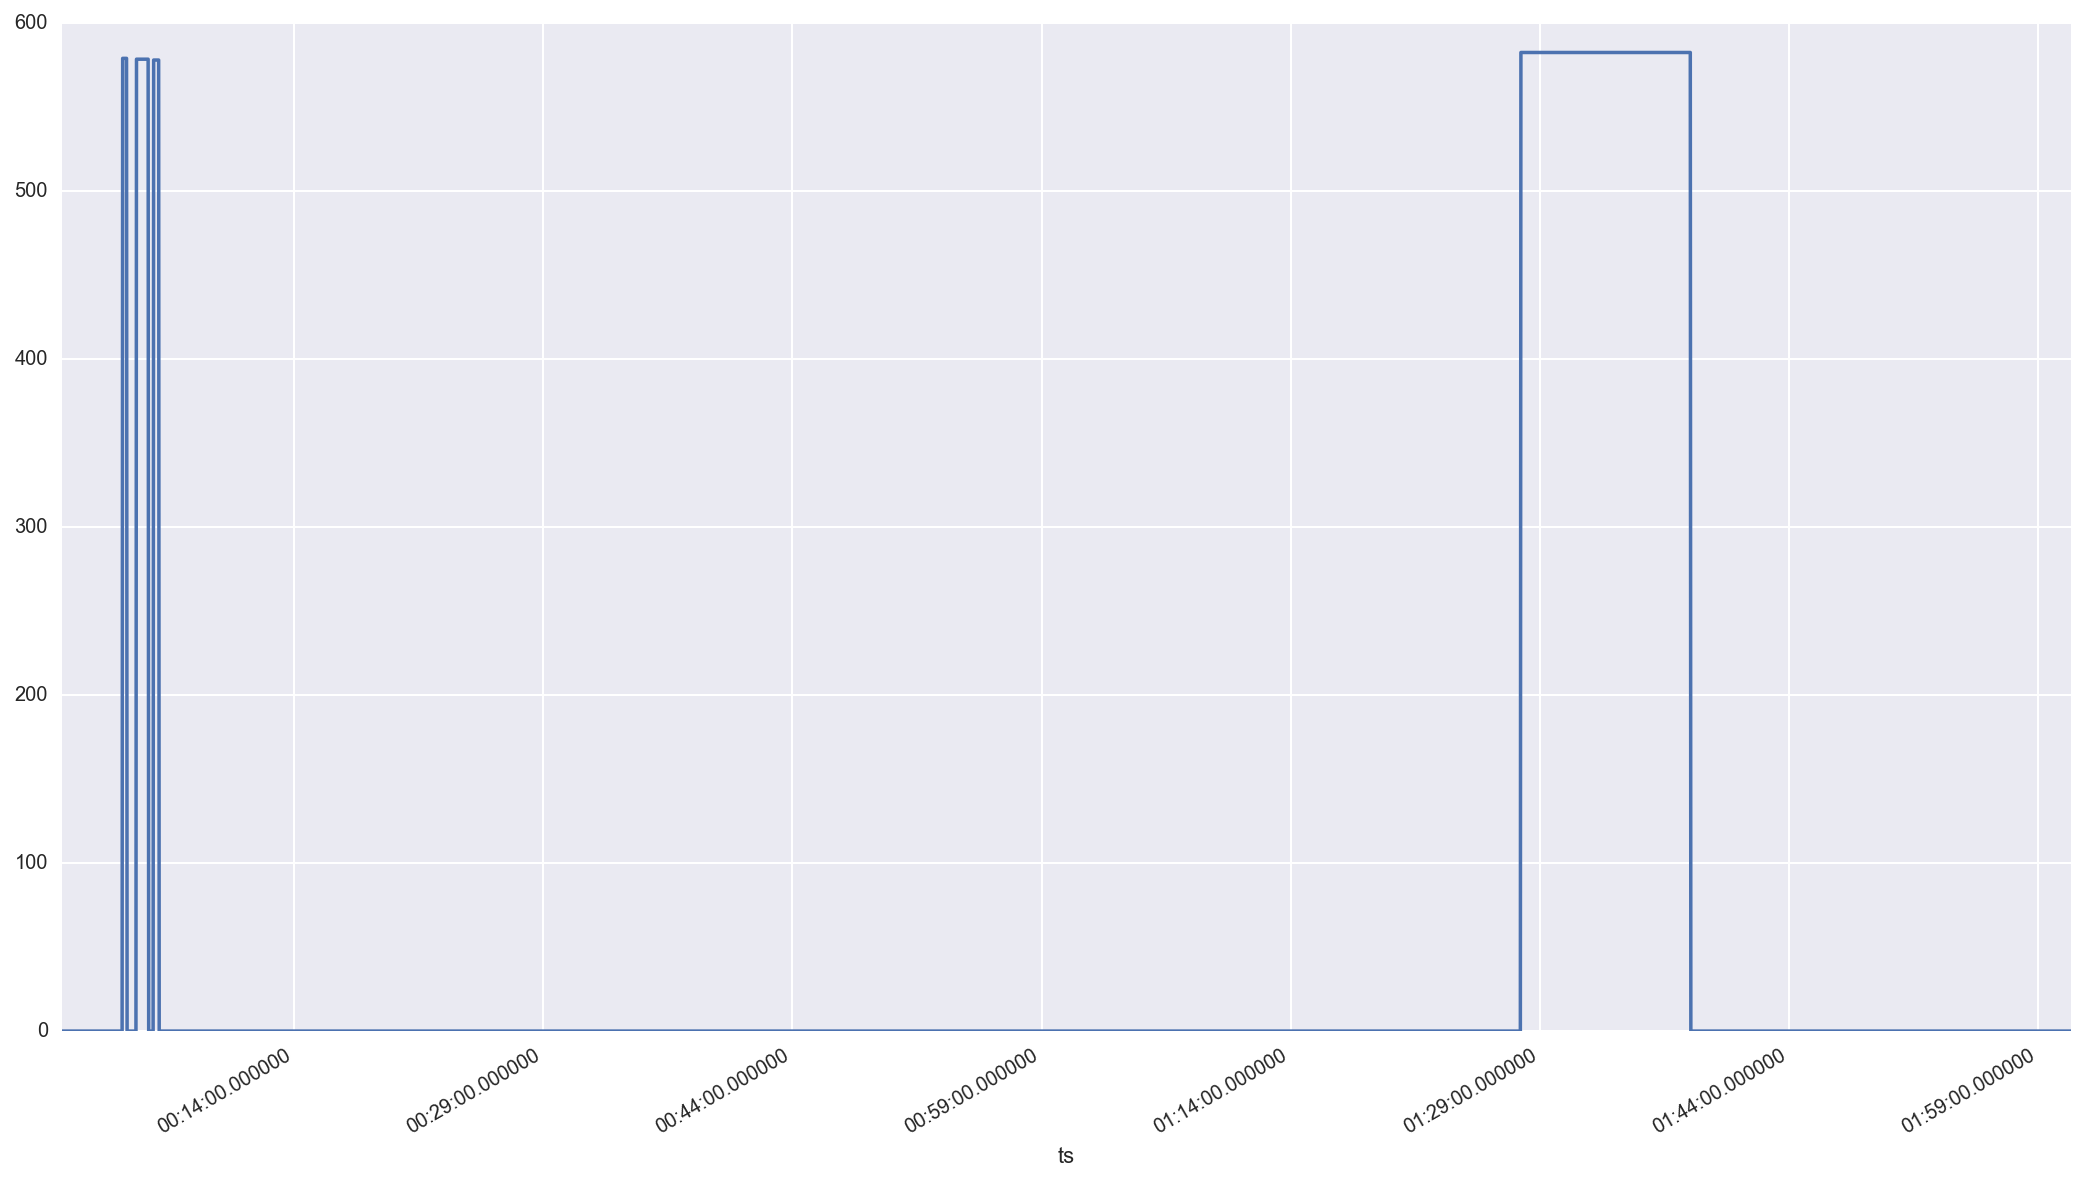

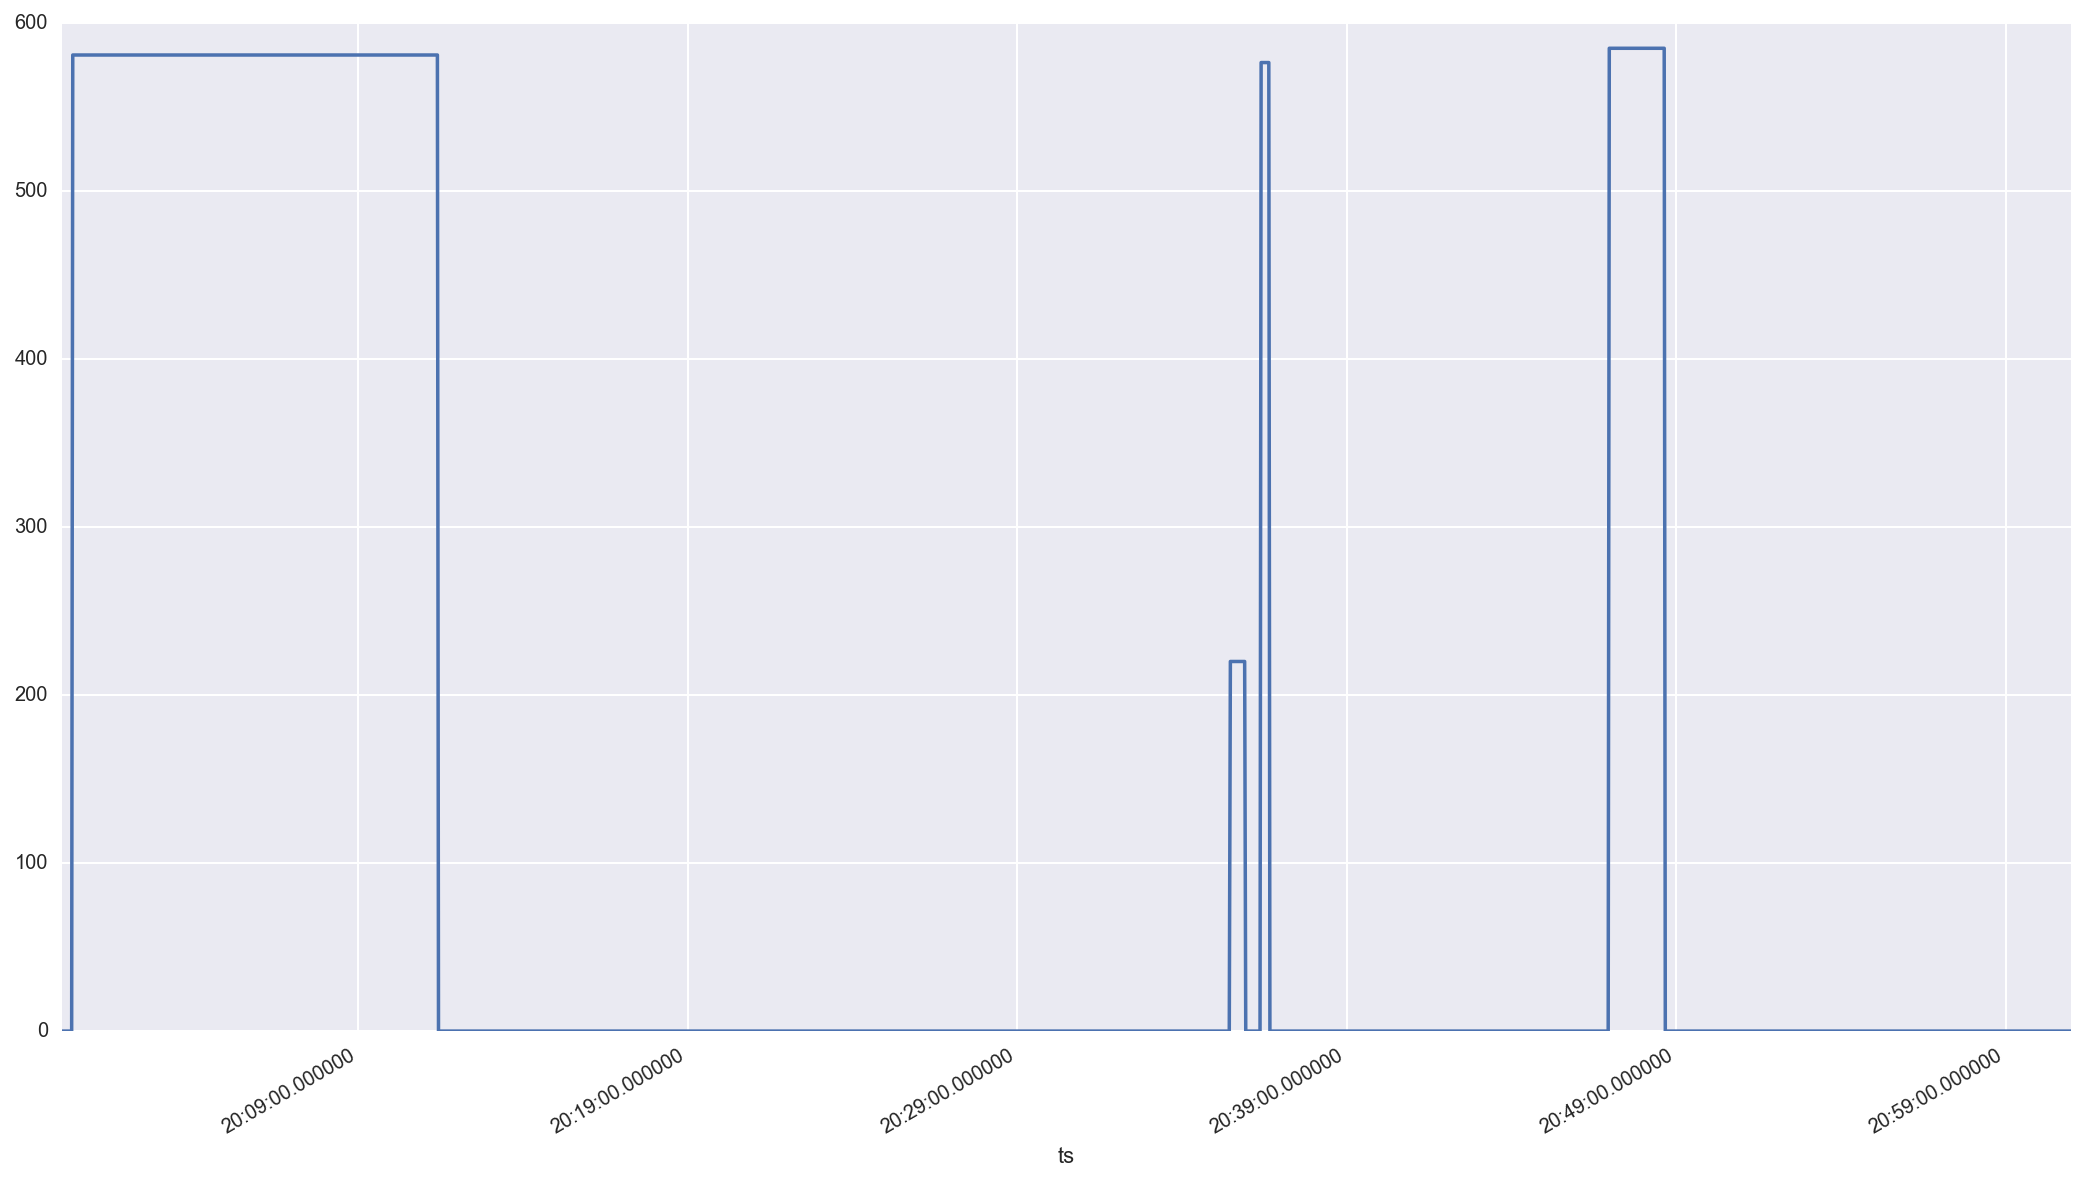

In [271]:
encendidos = cambios[cambios.ch_state == 1].index
apagados = cambios[cambios.ch_state == -1].index
data_analysis['artif_light'] = False
data_analysis['artif_level_max'] = 0
data_analysis['artif_level'] = 0
for i_enc in encendidos:
    apagado = apagados[apagados > i_enc]
    if len(apagado) > 0:
        apagado = apagado[0]
    if apagado:
        data_analysis.loc[i_enc:apagado, 'artif_light'] = True
        data_analysis.loc[i_enc:apagado, 'artif_level_max'] = data_analysis.ldr.loc[i_enc:apagado].max()
        #df_on = data_analysis.loc[i_enc: apagado]
        print_red('Encendido L={:.0f}, SEGS={:.0f}'.format(data_analysis.ldr.loc[i_enc:apagado].max(), (apagado - i_enc).total_seconds()))
        #print_cyan(df_on.ldr.describe().T)
        
        #ax = data_analysis.loc[i_enc - pd.Timedelta('1min'): apagado + pd.Timedelta('1min')].ldr.plot(figsize=(18, 5))
        #ax.scatter(x=i_enc, y=data_analysis.loc[i_enc, 'ldr'], color='red', marker='o', lw=0)
        #ax.scatter(x=apagado, y=data_analysis.loc[apagado, 'ldr'], color='blue', marker='o', lw=0)
        #plt.show()
    
ax = data_analysis['artif_level_max'].plot(figsize=(18, 10))
_tslim(ax, 0, 2)
plt.show()

ax = data_analysis['artif_level_max'].plot(figsize=(18, 10))
_tslim(ax, 20, 21)

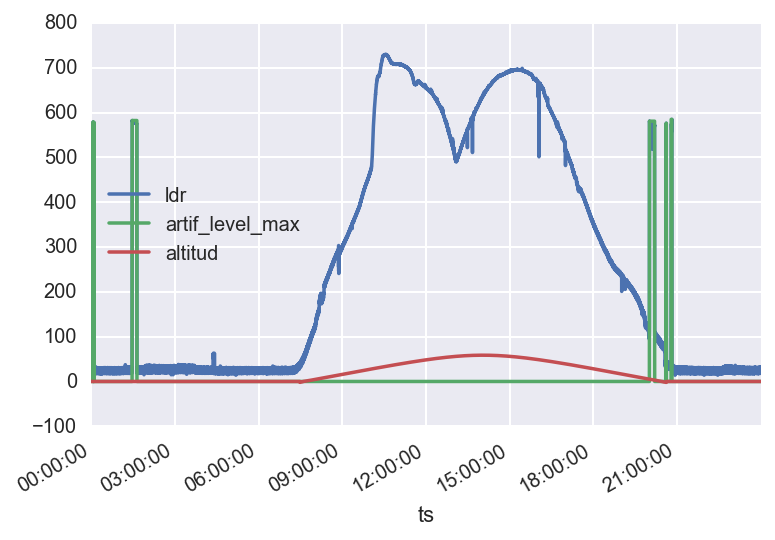

In [273]:
#data_analysis[apagado, 'ldr']
data_analysis[['ldr', 'artif_level_max', 'altitud']].plot()

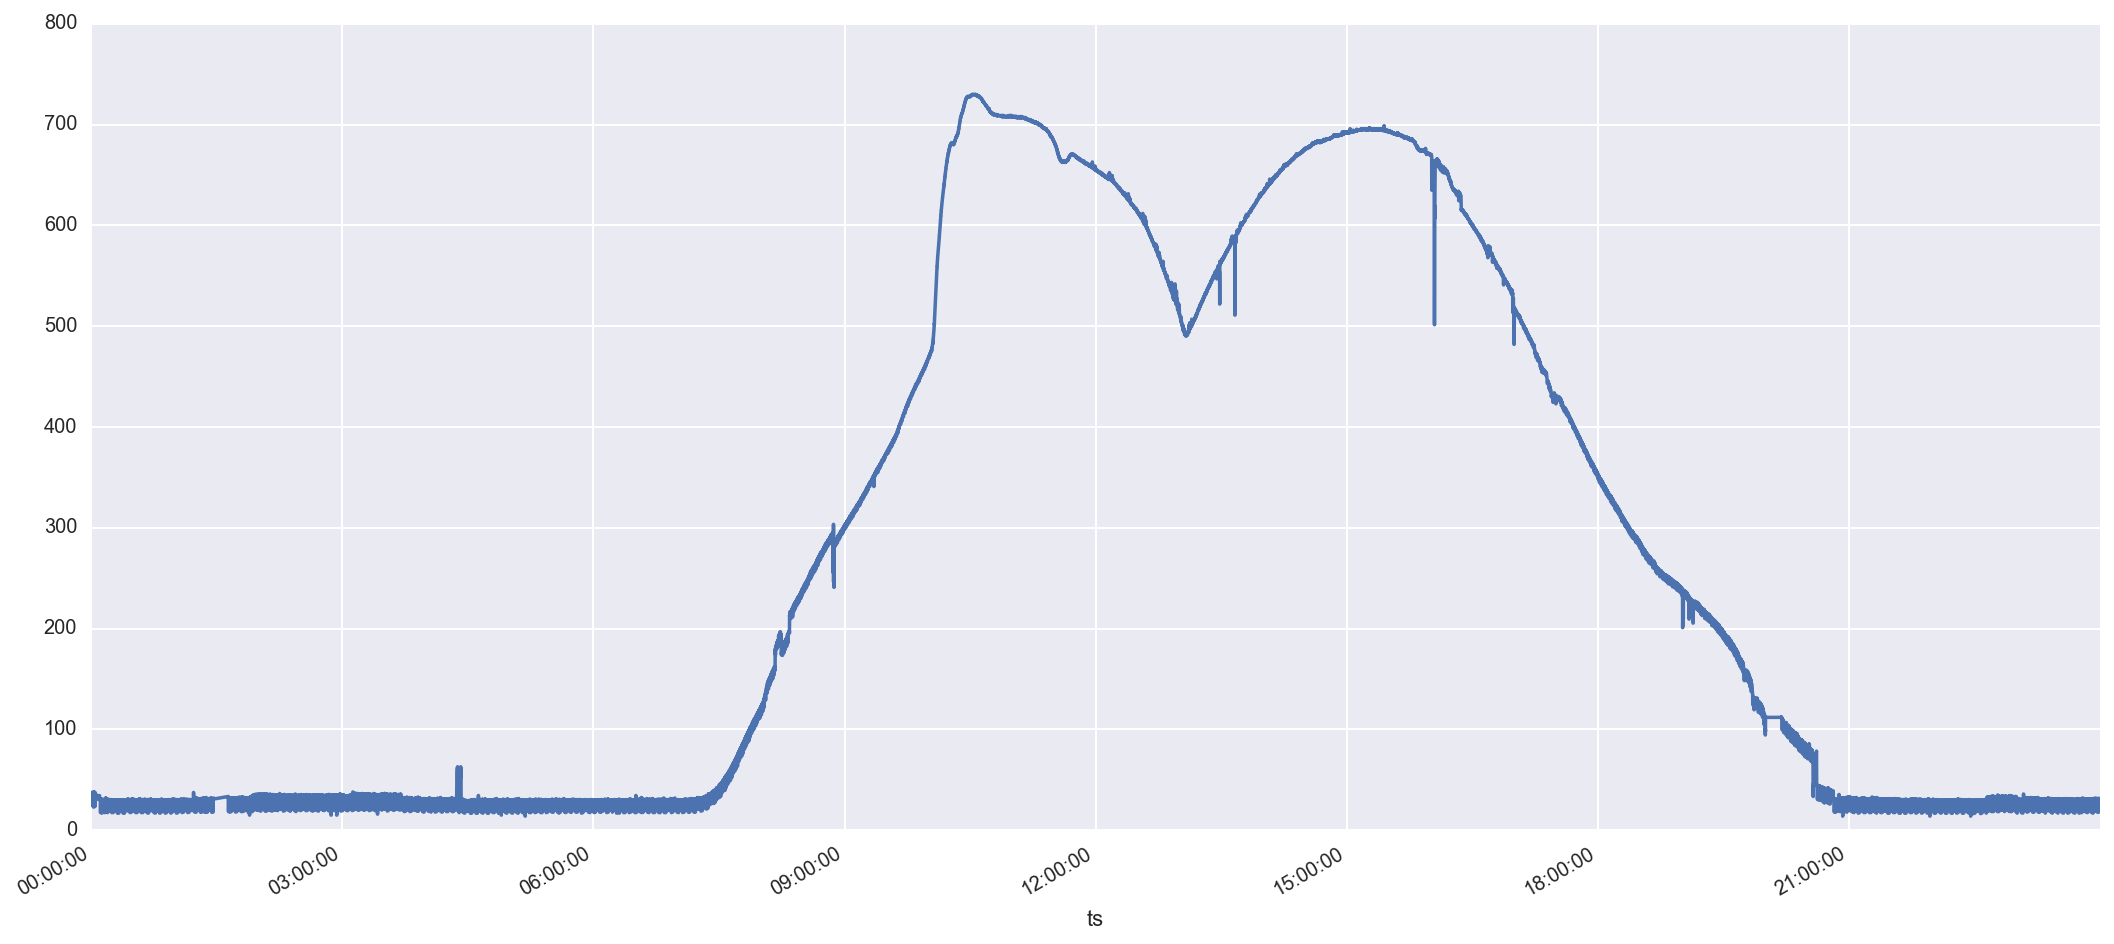

In [283]:
# Reconstrucción LDR natural: 
#data_analysis[data_analysis.artif_level_max > 0].index
index_art = data_analysis[(data_analysis.artif_level_max > 0).shift(-2) | (data_analysis.artif_level_max > 0).shift(2)].index
data_analysis.ldr.drop(index_art).resample('1min').max().interpolate().plot(figsize=(18, 8))

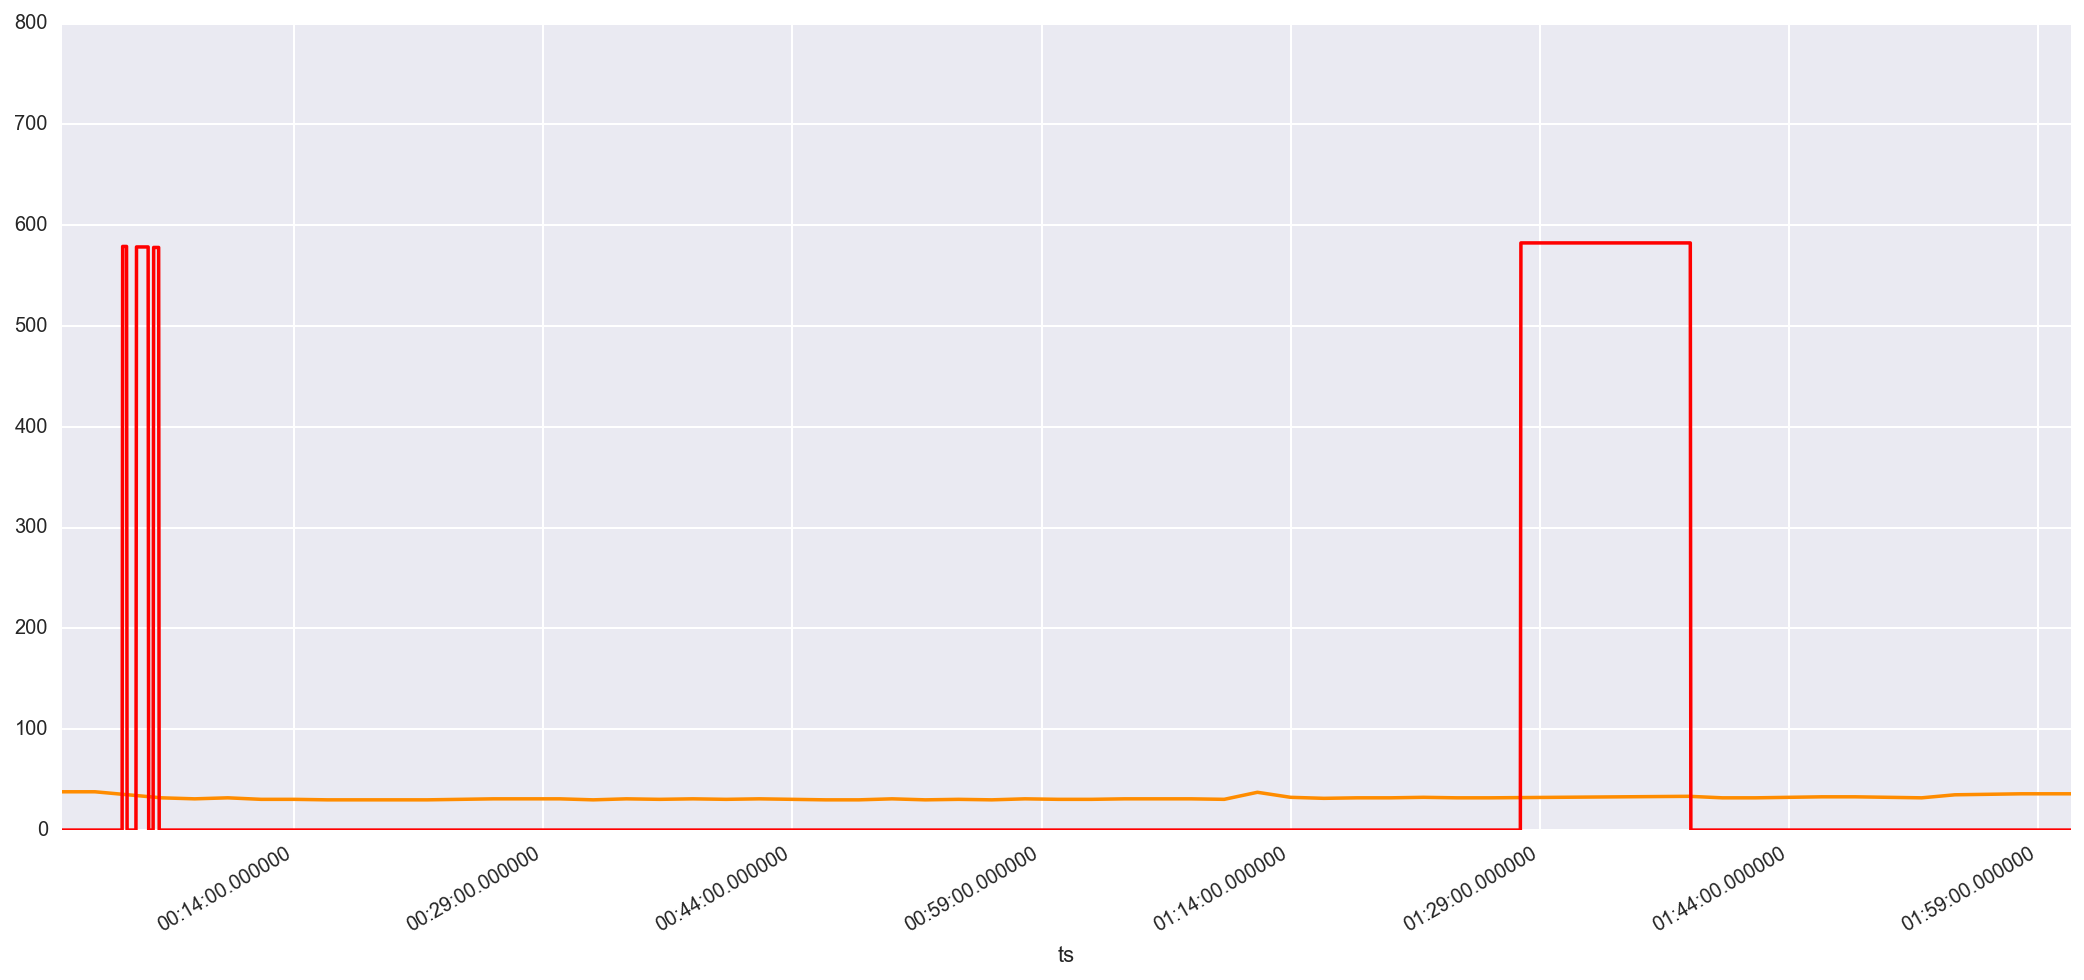

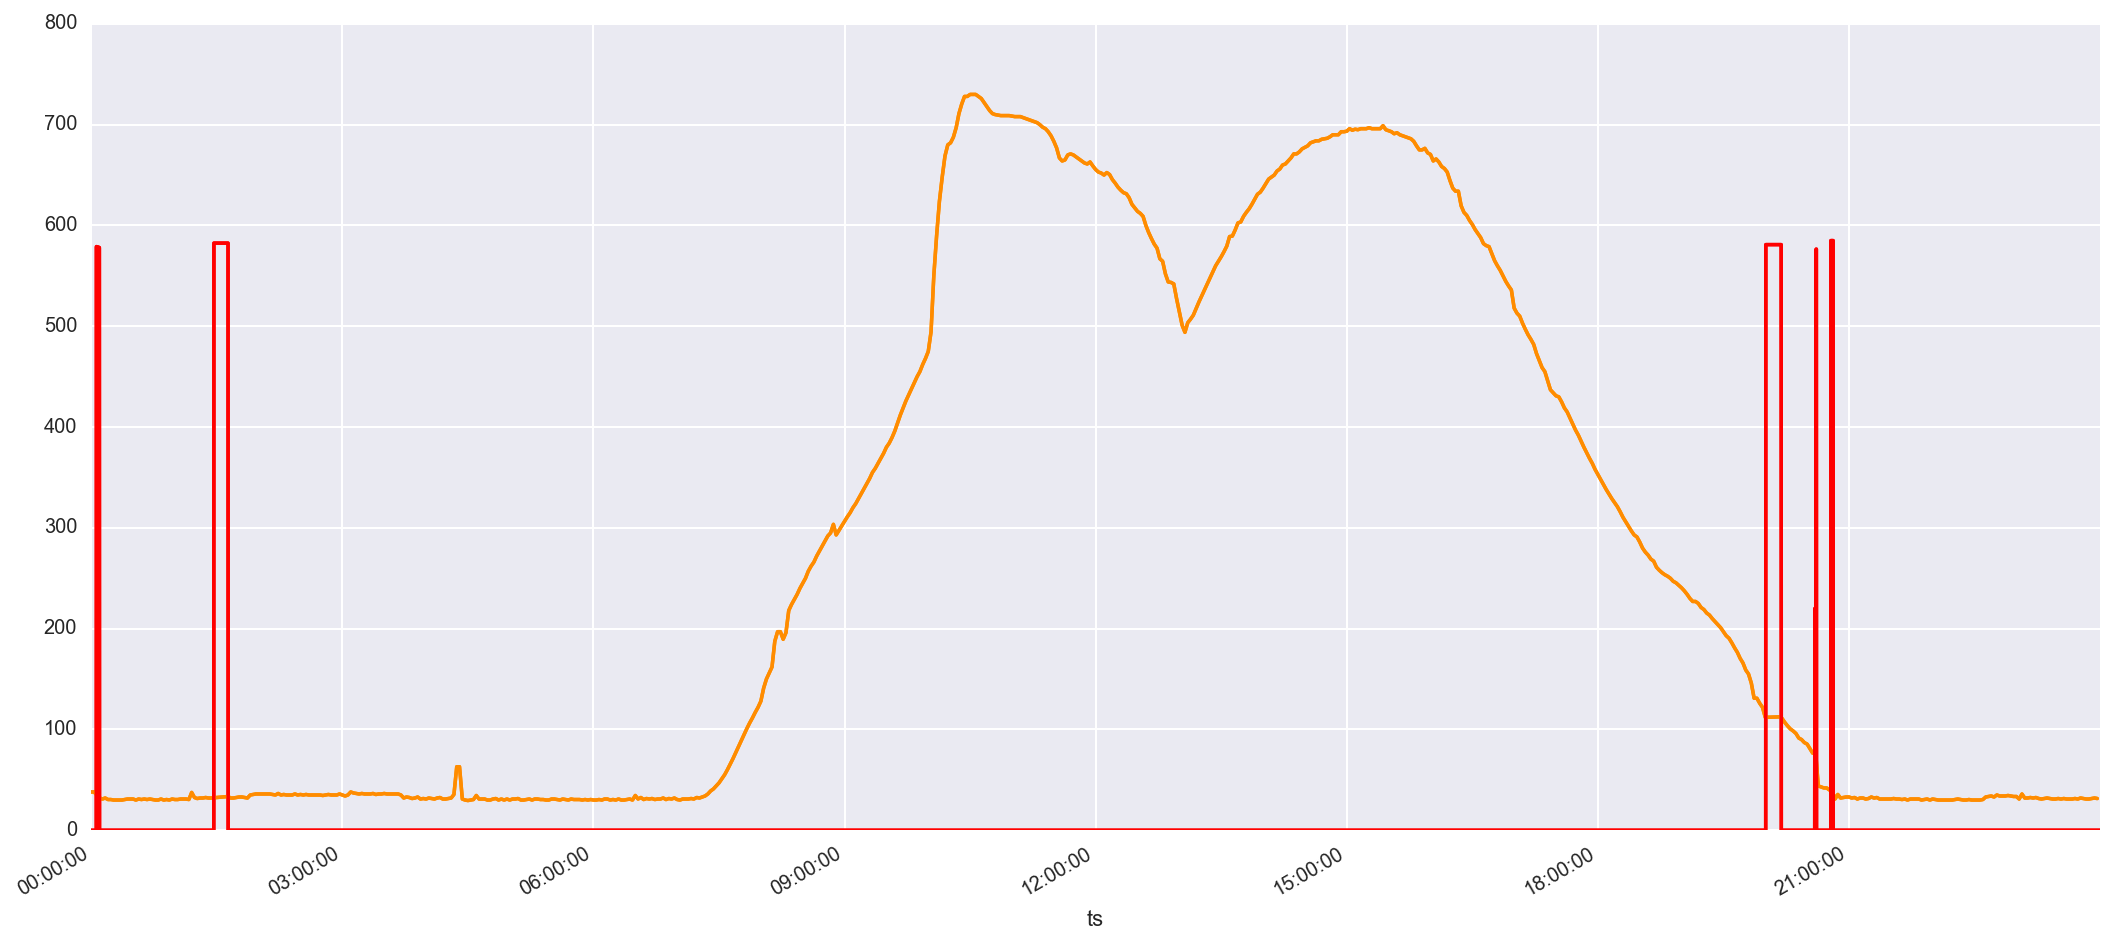

In [291]:
ax = data_analysis.ldr.drop(index_art).resample('2min').max().interpolate().plot(figsize=(18, 8), color='darkorange')
data_analysis.artif_level_max.plot(ax=ax, color='red')
_tslim(ax, 0, 2)
plt.show()

ax = data_analysis.ldr.drop(index_art).resample('2min').max().interpolate().plot(figsize=(18, 8), color='darkorange')
data_analysis.artif_level_max.plot(ax=ax, color='red')
_tslim(ax, 20, 22)

ax = data_analysis.ldr.drop(index_art).resample('2min').max().interpolate().plot(figsize=(18, 8), color='darkorange')
data_analysis.artif_level_max.plot(ax=ax, color='red')

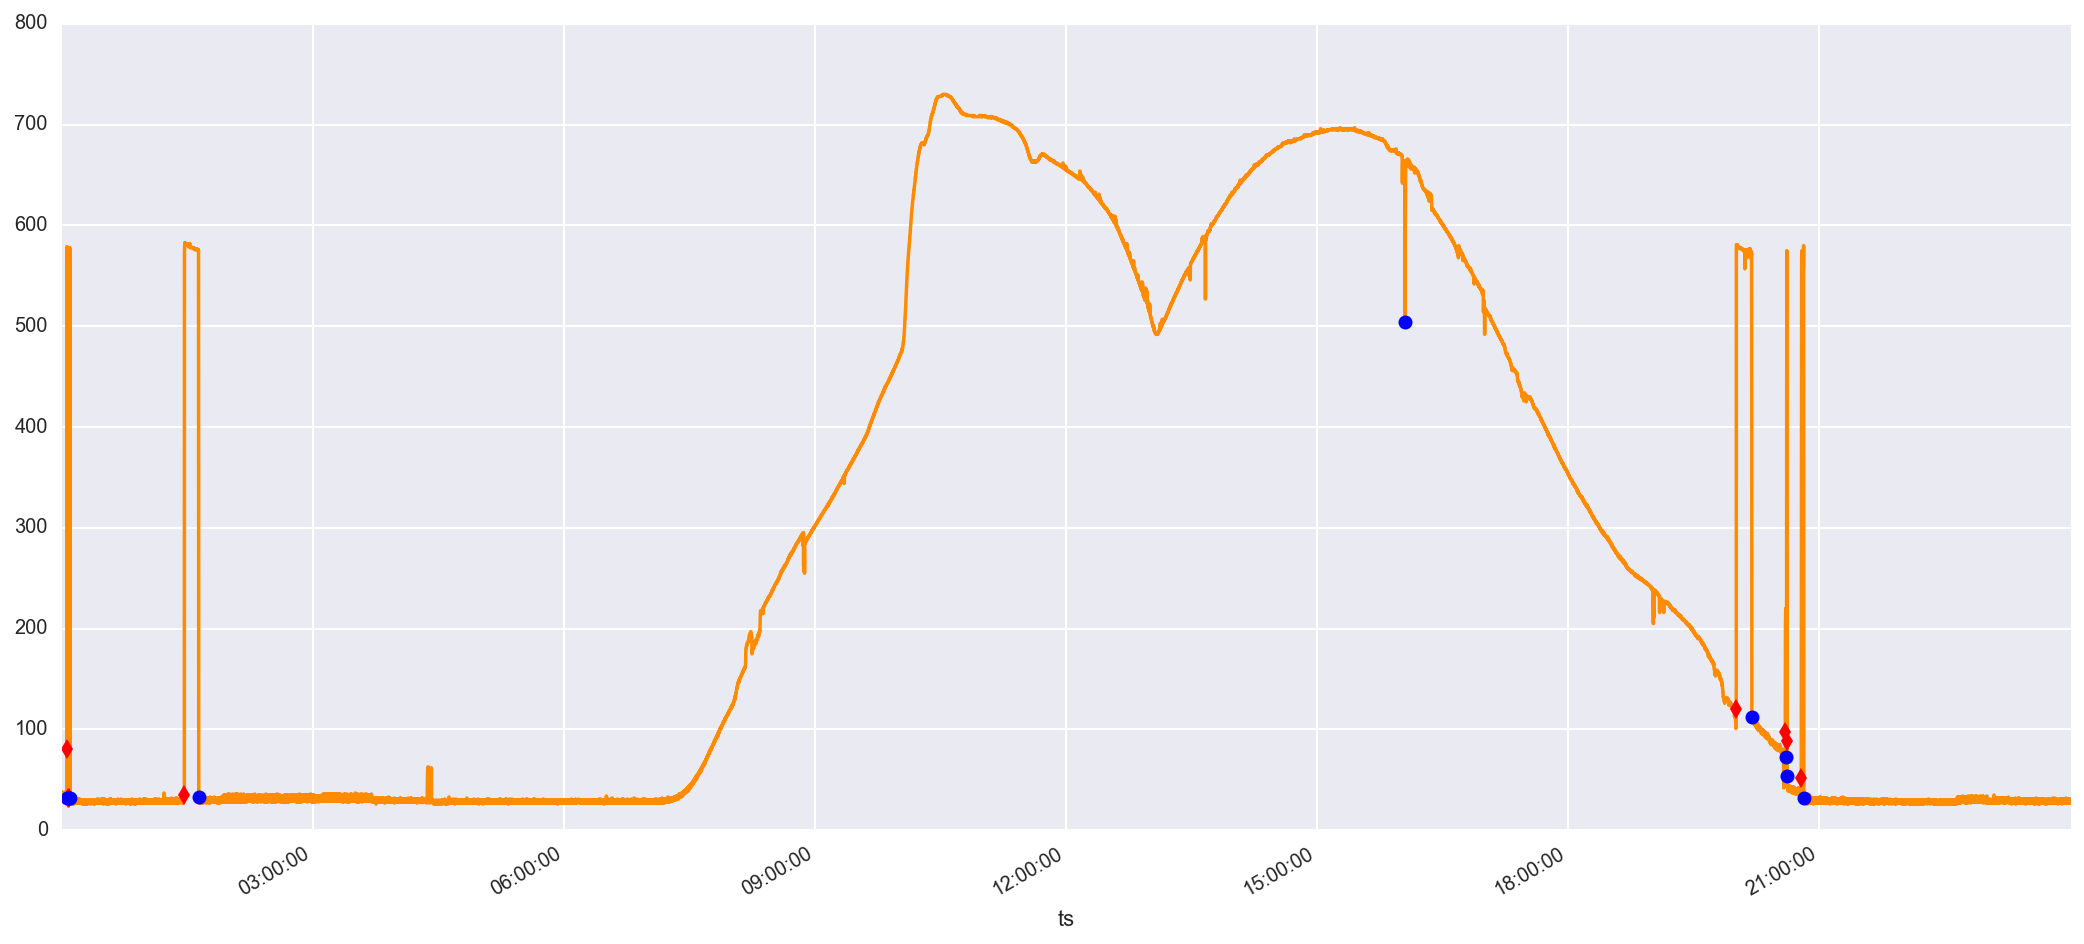

In [239]:
ax = data_day.iloc[::5].ldr.plot(figsize=(18, 8), color='darkorange')
encendidos.ldr.plot(marker='d', color='red', lw=0, ax=ax)
apagados.ldr.plot(marker='o', color='blue', lw=0, ax=ax)

In [296]:
data_analysis.join(data_analysis.ldr.drop(index_art).resample('2min').max().interpolate().rename('natural')).interpolate()

,ldr,altitud,azimut,irradiacion_cs,delta_roll,on,off,ch_state,artif_light,artif_level_max,artif_level,natural
ts,,,,,,,,,,,,
2016-09-03 00:00:00+02:00,36.5,0.0,0.000000,0.0,0.0,False,False,0,False,0.0,0,38.0
2016-09-03 00:00:02+02:00,37.0,0.0,0.000000,0.0,0.5,False,False,0,False,0.0,0,NaN
2016-09-03 00:00:04+02:00,37.0,0.0,0.000000,0.0,0.5,False,False,0,False,0.0,0,NaN
2016-09-03 00:00:06+02:00,37.0,0.0,0.000000,0.0,0.0,False,False,0,False,0.0,0,NaN
2016-09-03 00:00:08+02:00,37.0,0.0,0.000000,0.0,0.0,False,False,0,False,0.0,0,NaN
2016-09-03 00:00:10+02:00,37.0,0.0,0.000000,0.0,0.0,False,False,0,False,0.0,0,NaN
2016-09-03 00:00:12+02:00,37.0,0.0,0.000000,0.0,-0.5,False,False,0,False,0.0,0,NaN
2016-09-03 00:00:14+02:00,36.5,0.0,0.000000,0.0,0.0,False,False,0,False,0.0,0,NaN
2016-09-03 00:00:16+02:00,37.0,0.0,0.000000,0.0,0.5,False,False,0,False,0.0,0,NaN


In [293]:
data_analysis[['altitud', 'azimut', ]]

,ldr,altitud,azimut,irradiacion_cs,delta_roll,on,off,ch_state,artif_light,artif_level_max,artif_level
ts,,,,,,,,,,,
2016-09-03 00:00:00+02:00,36.5,0.0,0.000000,0.0,0.0,False,False,0,False,0.0,0
2016-09-03 00:00:02+02:00,37.0,0.0,0.000000,0.0,0.5,False,False,0,False,0.0,0
2016-09-03 00:00:04+02:00,37.0,0.0,0.000000,0.0,0.5,False,False,0,False,0.0,0
2016-09-03 00:00:06+02:00,37.0,0.0,0.000000,0.0,0.0,False,False,0,False,0.0,0
2016-09-03 00:00:08+02:00,37.0,0.0,0.000000,0.0,0.0,False,False,0,False,0.0,0
2016-09-03 00:00:10+02:00,37.0,0.0,0.000000,0.0,0.0,False,False,0,False,0.0,0
2016-09-03 00:00:12+02:00,37.0,0.0,0.000000,0.0,-0.5,False,False,0,False,0.0,0
2016-09-03 00:00:14+02:00,36.5,0.0,0.000000,0.0,0.0,False,False,0,False,0.0,0
2016-09-03 00:00:16+02:00,37.0,0.0,0.000000,0.0,0.5,False,False,0,False,0.0,0


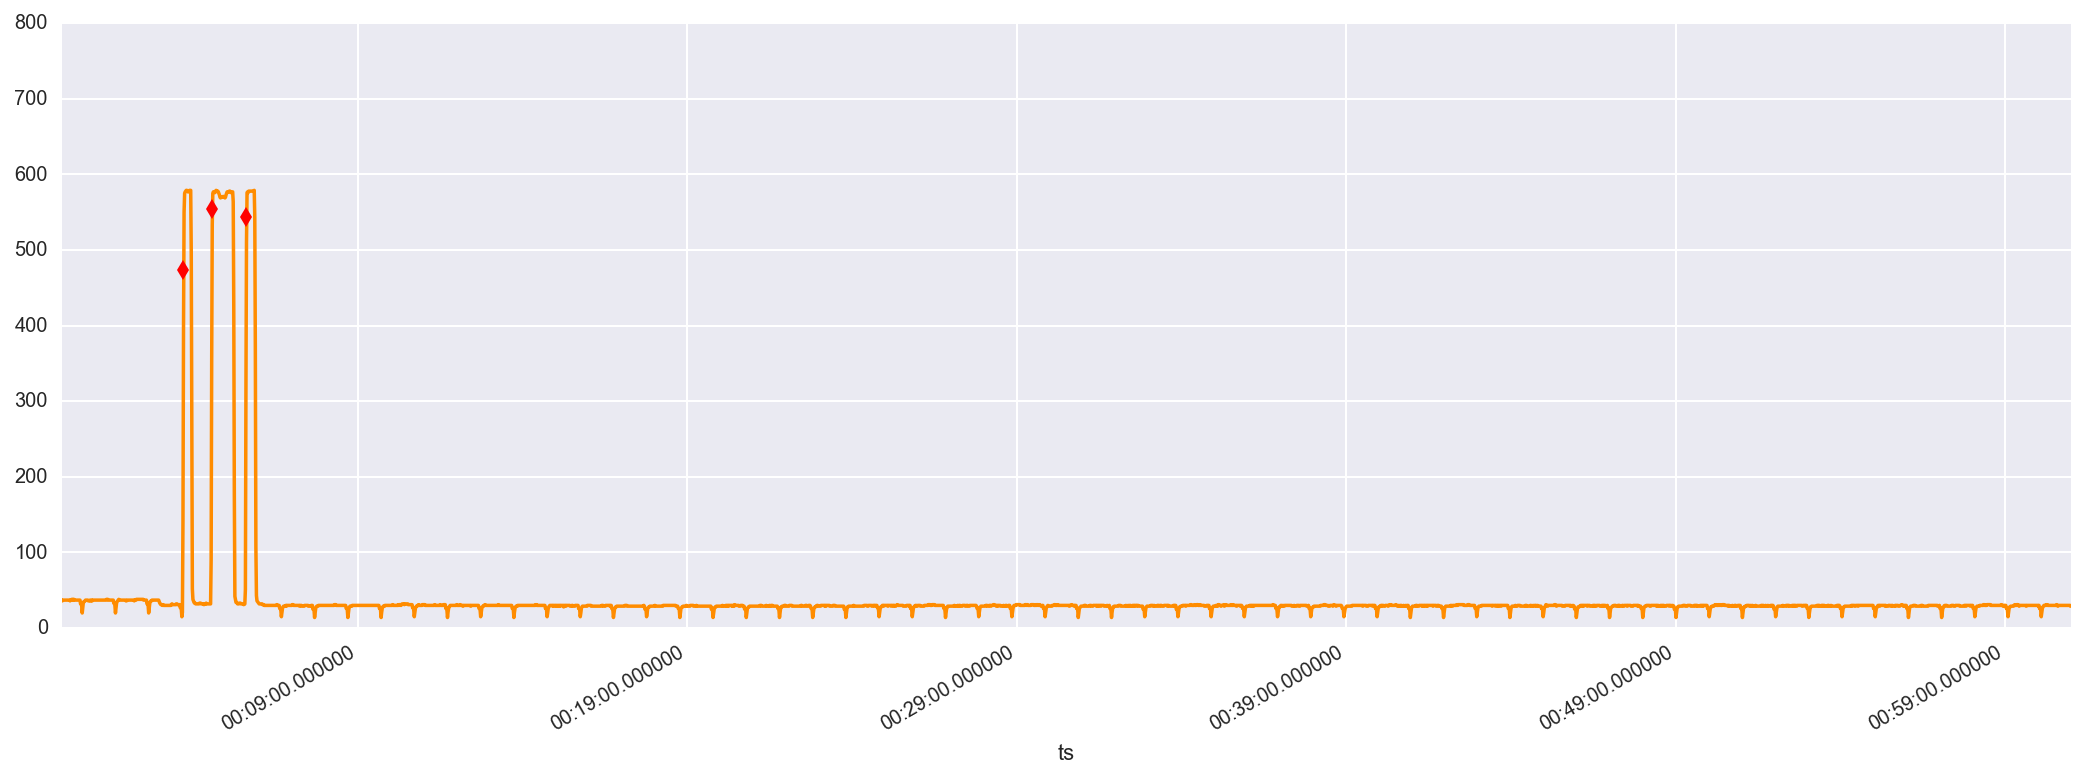

In [226]:
g_horas_enc = encendidos.groupby(lambda x: x.hour).groups
for hora, idx_enc in g_horas_enc.items():
    ax = data_day.ldr.plot(figsize=(18, 6), color='darkorange')
    encendidos.loc[idx_enc].ldr.plot(marker='d', color='red', lw=0, ax=ax)
    _tslim(ax, hora, hora + 1)
    plt.show()
    break



In [225]:
def _min_max_rel_m(x):
    print(type(x), len(x), x)
    #assert()
    mid = x[len(x) // 2]
    if mid == np.max(x):
        return 1
    elif mid == np.min(x):
        return -1
    return 0

data_analysis.iloc[:20][['ldr', 'delta_roll']].rolling(3, center=True).apply(_min_max_rel_m)

<class 'numpy.ndarray'> 3 [ 36.5  37.   37. ]
<class 'numpy.ndarray'> 3 [ 37.  37.  37.]
<class 'numpy.ndarray'> 3 [ 37.  37.  37.]
<class 'numpy.ndarray'> 3 [ 37.  37.  37.]
<class 'numpy.ndarray'> 3 [ 37.  37.  37.]
<class 'numpy.ndarray'> 3 [ 37.   37.   36.5]
<class 'numpy.ndarray'> 3 [ 37.   36.5  37. ]
<class 'numpy.ndarray'> 3 [ 36.5  37.   37.5]
<class 'numpy.ndarray'> 3 [ 37.   37.5  37.5]
<class 'numpy.ndarray'> 3 [ 37.5  37.5  37.5]
<class 'numpy.ndarray'> 3 [ 37.5  37.5  37. ]
<class 'numpy.ndarray'> 3 [ 37.5  37.   37. ]
<class 'numpy.ndarray'> 3 [ 37.  37.  37.]
<class 'numpy.ndarray'> 3 [ 37.  37.  37.]
<class 'numpy.ndarray'> 3 [ 37.  37.  37.]
<class 'numpy.ndarray'> 3 [ 37.  37.  32.]
<class 'numpy.ndarray'> 3 [ 37.  32.  25.]
<class 'numpy.ndarray'> 3 [ 32.   25.   30.5]
<class 'numpy.ndarray'> 3 [ 0.   0.5  0.5]
<class 'numpy.ndarray'> 3 [ 0.5  0.5  0. ]
<class 'numpy.ndarray'> 3 [ 0.5  0.   0. ]
<class 'numpy.ndarray'> 3 [ 0.  0.  0.]
<class 'numpy.ndarray'> 3 [ 0.

,ldr,delta_roll
ts,,
2016-09-03 00:00:00+02:00,NaN,NaN
2016-09-03 00:00:02+02:00,1.0,1.0
2016-09-03 00:00:04+02:00,1.0,1.0
2016-09-03 00:00:06+02:00,1.0,-1.0
2016-09-03 00:00:08+02:00,1.0,1.0
2016-09-03 00:00:10+02:00,1.0,1.0
2016-09-03 00:00:12+02:00,1.0,-1.0
2016-09-03 00:00:14+02:00,-1.0,0.0
2016-09-03 00:00:16+02:00,0.0,0.0


                            ldr
ts                             
2016-08-13 00:00:00.784081   32
2016-08-13 00:00:01.785146   32
2016-08-13 00:00:02.795937   32
2016-08-13 00:00:03.806606   31
2016-08-13 00:00:04.817211   32
81159


/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


29466


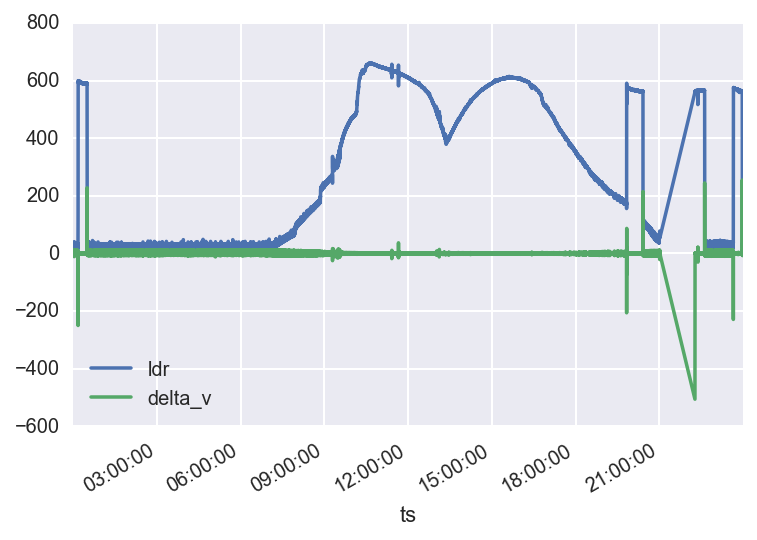

In [152]:
dday = _get_rday(LDR)
#.resample('5min').fillna(method='bfill').round(0).astype(int)
print_info(dday.head())
print_cyan(len(dday))

dday['delta_v'] = (dday['ldr'].shift(1) - dday['ldr']).fillna(0)
only_ch = dday[dday.delta_v != 0]

print_cyan(len(only_ch))

only_ch.plot()

In [157]:
# Limpieza de LDR:
# * ROLLING

dday['event'] = dday.delta_v.abs() > 50
dday.loc[dday['event'], 'event_s'] = dday[dday['event']].delta_v > 0
dday.sum()

/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

ldr        23686094.0
delta_v          -2.0
event            22.0
event_s          11.0
dtype: float64

In [159]:
dday[dday.event & dday.event_s]

,ldr,delta_v,event,event_s
ts,,,,
2016-08-13 00:29:29.438650,493,96.0,True,True
2016-08-13 00:29:30.449431,265,228.0,True,True
2016-08-13 00:29:31.460485,51,214.0,True,True
2016-08-13 19:49:56.597588,480,87.0,True,True
2016-08-13 20:24:55.144710,357,166.0,True,True
2016-08-13 20:24:56.155351,142,215.0,True,True
2016-08-13 22:37:29.622164,405,143.0,True,True
2016-08-13 22:37:30.624376,160,245.0,True,True
2016-08-13 22:37:31.625151,53,107.0,True,True


/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


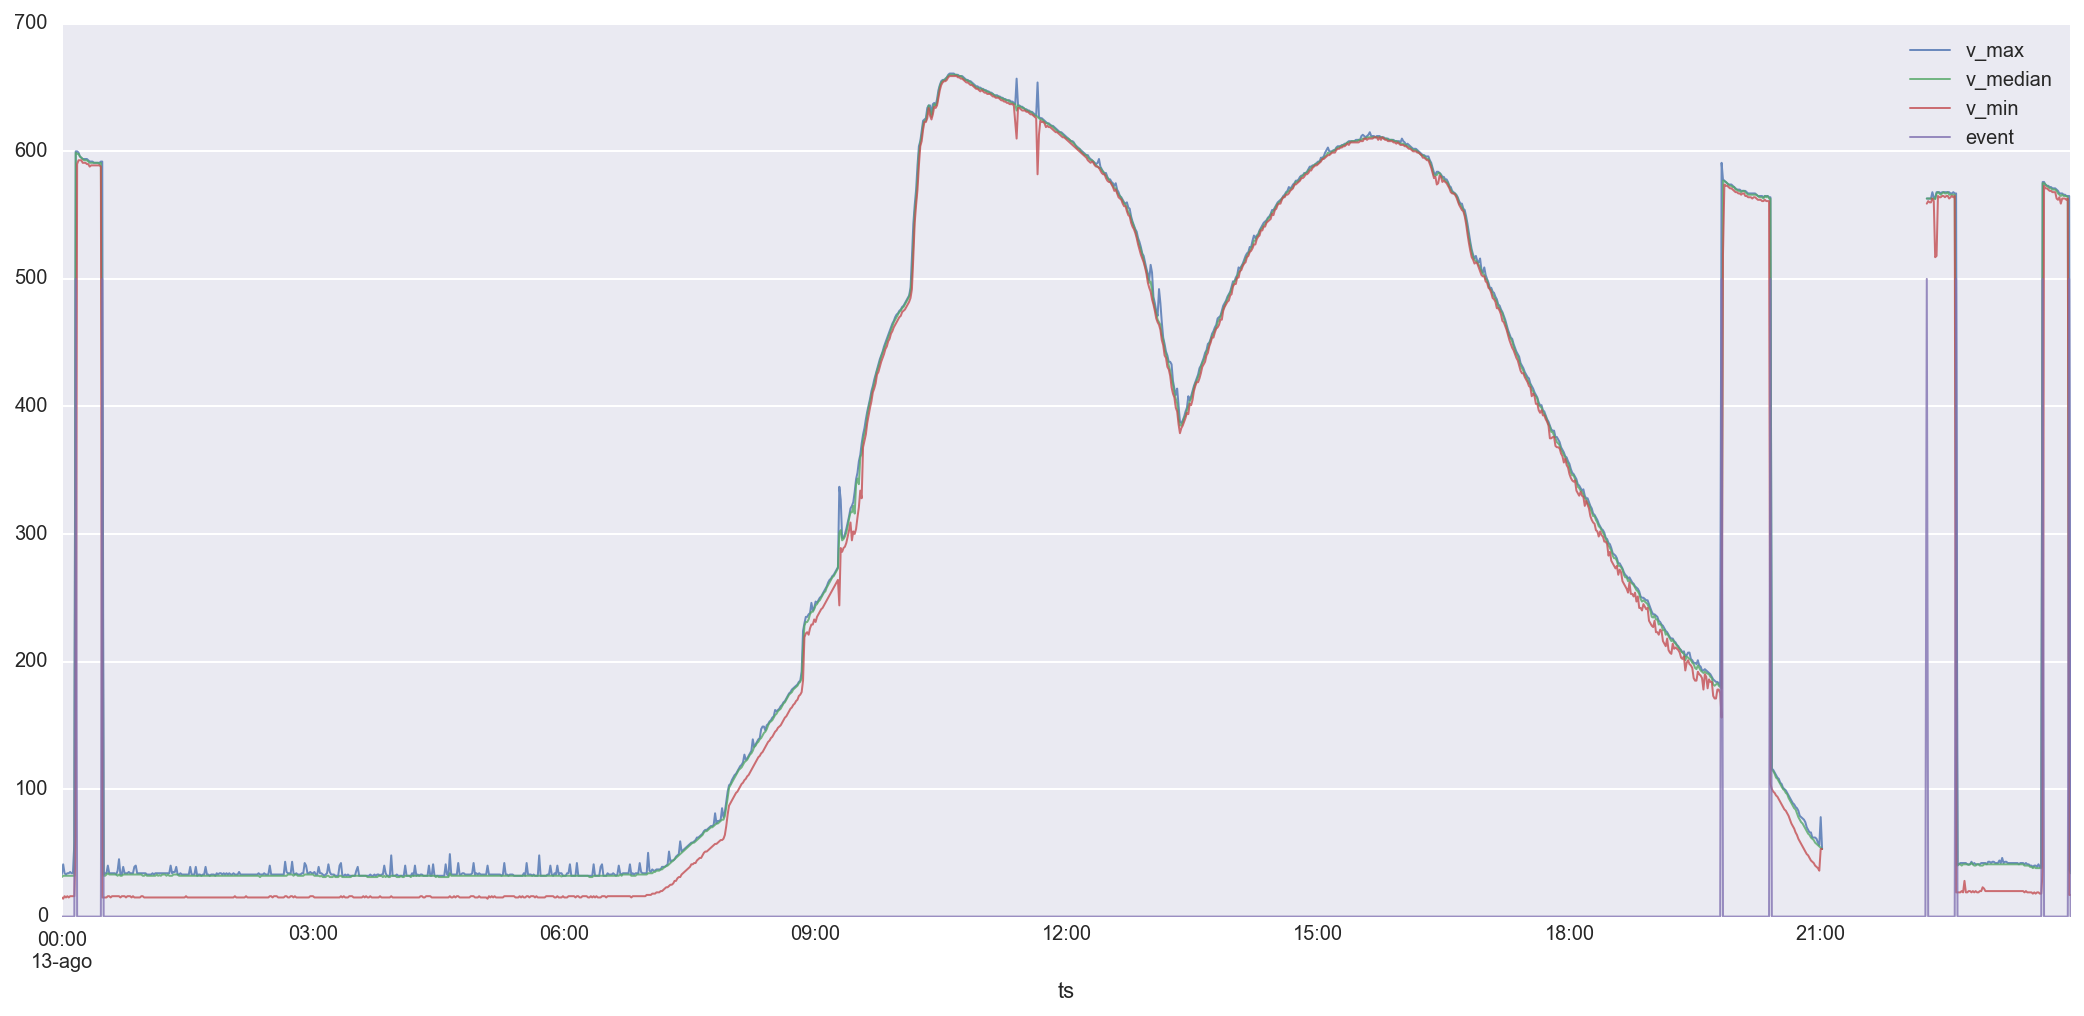

In [174]:
rs = dday.resample('1min')

ldr_dayrs = rs.ldr.apply(lambda x: pd.Series({'v_min': np.min(x), 
                                              'v_max': np.max(x), 
                                              'v_median': np.median(x)}) #.dropna().astype(int)
                        ).unstack()

#ldr_dayrs = ldr_dayrs.join((rs.event.sum() > 0) * 500)
ax = ldr_dayrs.plot(figsize=(18, 8), alpha=.8, lw=1)

(rs.event.sum() > 0) * 700

(736189.00000907504, 736189.99998833903)

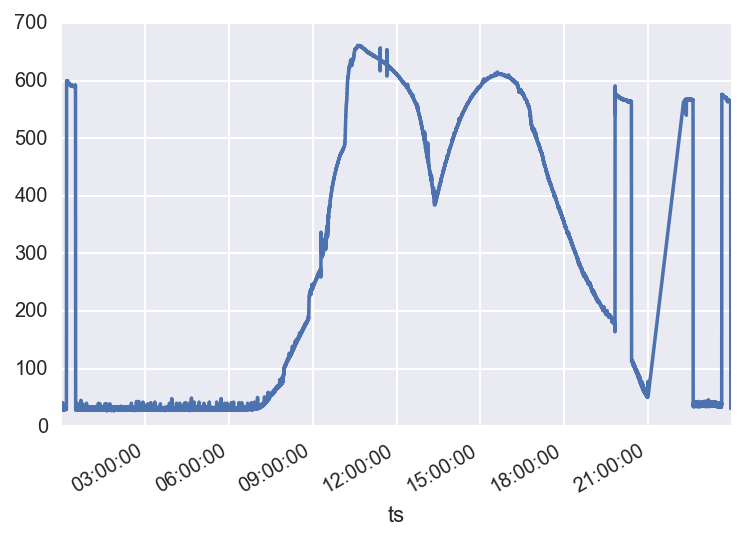

In [181]:
import matplotlib.dates as mpd


def _xlim_time(ax, t0, tf):
    xlim = ax.get_xlim()
    mpd.num.xlim[0]

dday.ldr.rolling(5).max().plot()
plt.gca().get_xlim()